# NYC MTA Turnstiles Data

The goal of this analysis is to answer and visualize the following questions:

Data analysis:
- Which station has the most number of units?
- What is the total number of entries & exits across the subway system for February 1, 2013?
- Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on February 1, 2013? What turnstile was the busiest on that date?
- What stations have seen the most usage growth/decline in 2013?
- What dates are the least busy? Could you identify days on which stations were not operating at full capacity or closed entirely?
- Bonus:  What hour is the busiest for station CANAL ST in Q1 2013?

Visualization:
- Plot the daily row counts for data files in Q1 2013.
- Plot the daily total number of entries & exits across the system for Q1 2013.
- Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.
- Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.
- Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q1 2013.

## Data collection

MTA Turnstiles data is downloadable as text files from http://web.mta.info/developers/turnstile.html. The files are in weekly chunks, so the easiest way to get the data is one week at a time by URL. I noticed that the format of the older files was particularly annoying to deal with (wide vs long), so I standardized across formats and parallelized by week. This sped up both pulling and munging the data substantially, which eliminated needing to worry about caching and storing the data locally.

Older data also is missing the station, linename, division mapping. I am using the Remote-Booth-Station file to get this info and, oddly enough, noticed that the column naming convention between the two appeared to be reversed. In the turnstile data, you have *C/A* and *UNIT* which seemed to correspond to *Booth* and *Remote* respectively in the excel file after taking a look at the unique values in both.

Lastly, all of the questions are relating to the Q1 2013 period, so I'll only be pulling that range but it is worth noting that, after parallelizing, the entire dataset can be pulled in memory in about 2 mins. 

More detailed comments inline with the code.

In [500]:
import pandas as pd
from multiprocessing import Process, Queue
from datetime import datetime
import time
import numpy as np
import seaborn as sns


# URL and file headers
url_template = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{date}.txt'
old_columns = 'C/A,UNIT,SCP,DATE1,TIME1,DESC1,ENTRIES1,EXITS1,DATE2,TIME2,DESC2,ENTRIES2,EXITS2,DATE3,TIME3,DESC3,ENTRIES3,EXITS3,DATE4,TIME4,DESC4,ENTRIES4,EXITS4,DATE5,TIME5,DESC5,ENTRIES5,EXITS5,DATE6,TIME6,DESC6,ENTRIES6,EXITS6,DATE7,TIME7,DESC7,ENTRIES7,EXITS7,DATE8,TIME8,DESC8,ENTRIES8,EXITS8'
current_columns = 'C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS'

# turn floats to ints with commas when printing
f_format = "{:,.0f}"
series_format = lambda x: f_format.format(x)

# Adding some lists for column groups that will be useful later
value_columns = ['ENTRIES','EXITS']
turnstile_key = ['C/A','UNIT','SCP']
# specify dtypes, fixes another 2012 bug
integer_dtypes = {k+'{}'.format(n):'float' for k in value_columns for n in range(1,9)}

# Pull in the excel file to map stations to pre 10/14/2018 data
#
# NOTE: normally I hate referencing a 'global' data frame inside a function
#       but this seemed to make more sense than re-pulling the Remote-Booth-Station file
#       inside the parallel process

stations = pd.read_excel(
    'http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls', 
    header=0, 
    names='UNIT,C/A,STATION,LINENAME,DIVISION'.split(','),
    usecols=[0,1,2,3,4],
)

def get_mta_data_for_date(date, queue):
    '''Pull MTA turnstile data for a single URL'''
    url = url_template.format(date=date.strftime("%y%m%d"))
    # print('processing {}'.format(url))
    if date < datetime(2014, 10, 18):
        # adding this for debugging, somethings wrong with 2012 data
        try:
            df = pd.read_csv(
                url,
                names=old_columns.split(','),
                na_values=['-'],
            )
            df = pd.wide_to_long(
                df.reset_index(), 
                stubnames=['DATE','TIME','DESC','ENTRIES','EXITS'], 
                i='index',j='record'
            ).reset_index(drop=True)
            
            # hacks to deal with dirty data
            # TODO: come back and fix this, this is super ugly right now 
            df = df[~df['C/A'].isin(['USE','NUMBER'])]
            df['ENTRIES'] = df['ENTRIES'].fillna(0).astype(int)
            df['EXITS'] = df['EXITS'].fillna(0).astype(int)
            # END HACK
            
            df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], format='%m-%d-%y %H:%M:%S')
            df = pd.merge(df, stations, how='left', on=['UNIT','C/A'])
        except:
            print("error processing {}".format(url))
    else:
        df = pd.read_csv(
            url,
            names=current_columns.split(','), 
            header=0,
        )
        df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], format='%m/%d/%Y %H:%M:%S')
    
    df = df.drop(columns=['DATE','TIME'])
    df = df.rename(columns={k: k+'_CUMULATIVE' for k in value_columns})
    queue.put(df)


In [351]:
# take a quick peek at stations
stations.describe()

,UNIT,C/A,STATION,LINENAME,DIVISION
count,768,768,768,768,768
unique,480,768,395,109,8
top,R195,A030,34 ST-PENN STA,1,IRT
freq,6,1,14,78,287


In [352]:
# pull data for the Q12013 period 
dates = pd.date_range(start='2012-01-07', end='2014-01-07', freq='W-SAT')
start = time.time()

results_queue = Queue()
procs = []

for date in dates:
    proc = Process(
            target=get_mta_data_for_date,
            args=(date,results_queue,),
        )
    procs.append(proc)
    proc.start()

results = [results_queue.get() for date in dates]
df = pd.concat(results, sort=False, ignore_index=True)

for p in procs:
    p.join()
    
end = time.time()
print('\n')
print('finished in {:.2f} seconds'.format(end - start))

/Users/josiabak/anaconda3/lib/python3.6/multiprocessing/popen_fork.py:73: DtypeWarning: Columns (6,7,11,12,16,17,21,22,26,27,31,36,37,42) have mixed types. Specify dtype option on import or set low_memory=False.
  code = process_obj._bootstrap()




finished in 258.83 seconds


In [353]:
# considering we have a nice datetime field to work with and now have one row per meter reading,
# let's set this to a datetime index
# also dropping null datetimes here as that corresponds to an interval where there was no meter reading
# this was introduced when going from the wide to long format

df_drop_nulls = df[~df['DATETIME'].isnull()]
df_dt_index = df_drop_nulls.set_index(['DATETIME'], drop=True)
df_dt_index.sort_index(inplace=True)

# df_dt_index_regular = df_dt_index[df_dt_index['DESC'] == 'REGULAR'] < more on this in the EDA section
df_dt_index.head()

,C/A,UNIT,SCP,DESC,ENTRIES_CUMULATIVE,EXITS_CUMULATIVE,STATION,LINENAME,DIVISION
DATETIME,,,,,,,,,
2011-12-31,R221,R170,01-03-01,REGULAR,2393884,3688460,14 ST-UNION SQ,LNQR456,IRT
2011-12-31,R258,R132,00-03-02,REGULAR,3315626,2666055,125 ST,456,IRT
2011-12-31,R258,R132,00-03-01,REGULAR,3100186,2847482,125 ST,456,IRT
2011-12-31,R258,R132,00-03-00,REGULAR,485191,553422,125 ST,456,IRT
2011-12-31,R258,R132,00-00-04,REGULAR,2252615,551431,125 ST,456,IRT


## Exploratory data analysis

In [354]:
df_dt_index.describe().style.format(f_format)

,ENTRIES_CUMULATIVE,EXITS_CUMULATIVE
count,"22,696,580","22,696,580"
mean,"4,154,410","2,813,271"
std,"24,239,529","24,559,058"
min,"-931,476,881","-878,997,156"
25%,"339,829","199,786"
50%,"1,941,602","1,224,143"
75%,"4,826,195","3,569,086"
max,"916,848,676","979,712,983"


Just a quick glance at `describe` shows that we have our work cut out for us in cleaning this data set.

This section will be a bit light on code and heavy on explanation, mainly due to the fact I was more interested in building an intuition for the data and writing a lot of code interactively that I didn't care to go back and formalize due to time constraints.

### Definitions

To start, I found the following from the MTA url very helpful:
```
C/A      = Control Area (A002)
UNIT     = Remote Unit for a station (R051)
SCP      = Subunit Channel Position represents an specific address for a device (02-00-00)
STATION  = Represents the station name the device is located at
LINENAME = Represents all train lines that can be boarded at this station
           Normally lines are represented by one character.  LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains.
DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND   
DATE     = Represents the date (MM-DD-YY)
TIME     = Represents the time (hh:mm:ss) for a scheduled audit event
DESc     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)
           1. Audits may occur more that 4 hours due to planning, or troubleshooting activities. 
           2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered. 
ENTRIES  = The comulative entry register value for a device
EXIST    = The cumulative exit register value for a device
```

Additionally, I found the MTA data dictionary from https://data.ny.gov/api/views/v5y5-mwpb/files/ec39f93c-374f-4efc-8ba1-5636ecfbacb9?download=true&filename=MTA_Turnstile_Data_DataDictionary.pdf, which proved very helpful in understanding the data.

Essentially, considering these values are cumulative, you can still get a fairly accurate picture even if entire chunks of the data are missing. Because of this, I initially considered removing everything except the "REGULAR" description, but after looking at the data more decided there was no reason to. This is because most of the "DOOR OPEN", "LOGON", etc events don't really affect cumulative totals much. I also felt it was helpful to have the "RECOVR AUD" event in case there was a large period of time where a device was offline (more than a day, for example). My general rule is "If you are unsure about removing data, don't."

### Getting ENTRY and EXIT counts

I'll give more detailed comments in the code, but the idea here was to de-dupe the counts. In summary:

- First, sort the data by timestamp ascending
- I defined `turnstile_key`, based off the definitions and looking at the data, as a unique turnstile (or recording device)
- Group by turnstile key and subtract the first value from the next and so on (this was quite graceful with `df.diff()`)

After that, I spend some time looking at the *ENTRY* and *EXIT* fields. It's pretty clear that there are some extreme values which shouldn't be there, but the data also contains outliers. For example, some of the readings from a single turnstile where in the hundreds of millions, which is obviously not true. Additionally, I noticed negative values, which intuitively could be caused by a meter reset, as described in the documentation (this is when a meters counter resets to some predetermined register value). But just using outlier detection won't work because the data also has true outliers that I want to keep, such as high meter readings due to a major event (think New Years Eve).

Outlier detection is also problematic given that different stations might have very different patterns. I played around with outlier detection per station (using the turnstile key), and a variety of outlier detection methods (Chebyshev's theorem, Tukey's box plots, median rule, modified z-score), before realizing I was making this harder than it needed to be. Ideally, the best way to clean data is a-priori information (e.g. "anything above/below this value is unrealistic because...").

**NOTE**: I will say in general I prefer a more robust, scalable approach where I make as few assumptions as possible (never assume the data comes from a normal distribution), and try to infer as much as I can from the data itself without relying on outside information. Why? Because this scales to massive datasets where you might not know anything about the data. But in reality, a lot of times a good intuition can be built using a-priori knowledge, so why not use it? It is a far more pragmatic approach.

In the end, I did the following thought experiment to clean the data

#### What is a sensible meter reading? 

A sensible meter reading is defined as:
- Greater than 0 (this is because meters act as an odometer and can only be negative if reset/faulty)
- Less than a `max_turnstile_capacity` number

I came up with `max_turnstile_capacity` via the following thought experiment

In [356]:
print("What is the total number of turnstiles on a given day: {}".format(
    df_dt_index['2013-02-01'].groupby(turnstile_key)[turnstile_key].nunique().shape[0]
))

What is the total number of turnstiles on a given day: 4417


given that number (4417 turnstiles on 2/01/2013), we know there is about 8.62M people in NYC. So how many meter readings would we expect from a *single* turnstile if `x` percentage of people were passing through `y` percentage of the turnstiles at any given time.

Realistically, not all 8M people are always using the subway and in some instances it could be more (again, think NYE). Also, not all turnstiles are going to be in use constantly.. so this is a super crude estimate. But just to get a sense, lets take the different percentages of the total NY population and disperse them across different percentages of turnstiles and see what that spread looks like:

In [357]:
# say 5%, 10%, 15%, etc of all NYC is traveling at any given time
daily_travelers_dist = 8623000 * np.arange(0.05,1, .05)

# and say they are using 5% (meaning everyone cramming into one turnstile) to 95% (using the whole subway system)
# at any given time
station_in_use_dist = 4450 * np.arange(0.05,1, .05)

total_people_per_station = pd.Series([x / y for x in daily_travelers_dist for y in station_in_use_dist])
total_people_per_station.describe()

count      361.000000
mean      3618.232887
std       5284.796764
min        101.986990
25%       1019.869899
50%       1937.752809
75%       3681.730337
max      36817.303371
dtype: float64

So based on that, 36,628 is an upper bounds of sorts. The max is the equivalent of saying 95% of the total population of NYC is using 5% of the turnstiles, so 36k people per turnstile for one reading (in our dataset, one reading is more or less a 4 hour period).

Can a turnstile even support 36k in a four hour period? Let's say it takes 2 seconds for a person to walk through a turnstile.. if people were walking single file through a single turnstile all day, that would give us the following:

In [358]:
max_turnstile_capacity = 24*60*60/2
print(max_turnstile_capacity)

43200.0


Given that we don't really expect more than 36k New Yorkers to be at any give turnstile, and the max the turnstile could do anyways if it was smoking away at a person every 2 seconds is 43k, I feel like 43k is a very safe upper bound. Safe in the sense that we aren't sensoring too much data (mainly I'm thinking a turnstile could not be transmitting for 2 or more days and accumulate for awhile), but not so big we are letting weird data in, as observed previously.

**TLDR;** No negatives, nothing bigger than `max_turnstile_capacity`, be careful removing data

In [359]:
# For brevity, I am removing all of the outlier comparison code. It was really messy and interactive
# and only served to build an intuition on the data set. The final approach is summarized above

def get_entries_and_exits(v):
    '''
    IMPORTANT: The data has to be sorted by timestamp in ascending order
    for this to work. If it is, the first entry will be NaN (no previous value)
    and everything else will be ROW - (PREVIOUS_ROW)
    '''
    return v.diff()

# don't even mess with z-score or modified z-score, too many assumptions about the data
# and sensitive to extreme values

def turnstile_outliers_std(df, col, threshold=3, remove=True):
    '''
    For normal, use 3 std deviations for 95% of the data
    For non-normal, use Chebyshev’s theorem (4.5 std deviations for at least ~95% of the data)
    '''
    if remove:
        return df[~(np.abs(df[col]-df[col].mean()) > (threshold*df[col].std()))]
    else:
        return df[(np.abs(df[col]-df[col].mean()) > (threshold*df[col].std()))]

# IQR was promising, but still kicking out a lot of valid data points due to the skewness
# I tried messing around with adjusted IQR but that point realized this was overkill
def turnstile_outliers_iqr(df, col, remove=True):
    '''
    Using Tukey's, as it makes less assumptions about the data
    This is still highly sensitive to skewness, which I imagine this data is 
    '''
    first_quantile = df[col].quantile(.25)
    third_quantile = df[col].quantile(.75)
    iqr = third_quantile - first_quantile
    lower = first_quantile - 3*iqr
    upper = third_quantile + 3*iqr
    if remove:
        return df[((df[col] >= lower) & (df[col] <= upper))]
    else:
        return df[~((df[col] >= lower) & (df[col] <= upper))]
    

# Each group represents a sorted turnstile
turnstiles = df_dt_index.groupby(turnstile_key, as_index=False)

In [360]:
# get the entries and exits by diffing
# NOTEWORTHY EXAMPLES
# -678035455.0
# this appears to be the register value for N182, R414, 00-03-01
# also R206, R014
# so values can either increment or decrement and then reset at predefined intervals?

df_dt_index = df_dt_index.assign(
    ENTRIES=turnstiles['ENTRIES_CUMULATIVE'].transform(get_entries_and_exits),
    EXITS=turnstiles['EXITS_CUMULATIVE'].transform(get_entries_and_exits),
)

# remove any negative values (again, this is because they should only occur when a meter resets or a bad read)
# interestingly enough, I did notice negative readings in the cumulative value, but in the opposite direction
# so they worked fine. I am assuming this has something to do with a turnstile getting screwed up and turning the wrong
# direction? Would like to understand more if I had more time

df_dt_index_positive = df_dt_index[(df_dt_index['ENTRIES'] >= 0) & (df_dt_index['EXITS'] >= 0)]

In [361]:
# remove outliers using max_turnstile_capacity
# also save the outliers for inspection

df_dt_index_positive_outliers_removed = df_dt_index_positive[
    (df_dt_index_positive['ENTRIES'] <= max_turnstile_capacity) & 
    (df_dt_index_positive['EXITS'] <= max_turnstile_capacity)
]

inspect_outliers = df_dt_index_positive[
    (df_dt_index_positive['ENTRIES'] > max_turnstile_capacity) | 
    (df_dt_index_positive['EXITS'] > max_turnstile_capacity)
]

In [362]:
inspect_outliers.describe().style.format(f_format)

,ENTRIES_CUMULATIVE,EXITS_CUMULATIVE,ENTRIES,EXITS
count,"7,829","7,829","7,829","7,829"
mean,"4,061,458","4,200,201","2,022,221","4,317,799"
std,"25,572,392","29,487,647","26,894,229","30,731,411"
min,0,"-1,443,038",0,0
25%,"1,723,127","1,879,334",0,"1,879,283"
50%,"1,727,448","1,886,053",0,"1,886,022"
75%,"3,267,142","4,345,853",1,"4,345,829"
max,"838,910,526","979,712,983","835,617,660","971,924,691"


In [363]:
# worth noting, the biggest value in Entries and Exits is now 24.8k, which holds up nicely with the thought experiment
df_dt_index_positive_outliers_removed.describe().style.format(f_format)

,ENTRIES_CUMULATIVE,EXITS_CUMULATIVE,ENTRIES,EXITS
count,"22,670,884","22,670,884","22,670,884","22,670,884"
mean,"4,155,828","2,814,416",159,126
std,"24,241,128","24,560,597",375,294
min,"-931,476,881","-878,997,156",0,0
25%,"339,937","200,576",2,2
50%,"1,942,673","1,224,853",53,38
75%,"4,829,582","3,570,305",210,147
max,"916,848,676","979,712,983","43,200","40,679"


In [365]:
# df_dt_index_positive_outliers_removed.to_csv('cleaned_data.csv', index=False)

## Formal data analysis
- Which station has the most number of units?
- What is the total number of entries & exits across the subway system for February 1, 2013?
- Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on February 1, 2013? What turnstile was the busiest on that date?
- What stations have seen the most usage growth/decline in 2013?
- What dates are the least busy? Could you identify days on which stations were not operating at full capacity or closed entirely?
- Bonus:  What hour is the busiest for station CANAL ST in Q1 2013?

#### Number of units

Not totally clear what time frame, but we can assume a station has a relatively fixed number of units over time. Also, assuming a unit is a *UNIT* per the data and not a turnstile (*C/A*,*UNIT*,*SCP*).

Given that, CANAL ST and 86 ST are tied at 5 *UNITS* per station. 34 ST-PENN STA wins by having the most *CONTROL AREA*'s with 14.

In [366]:
# check for a day
df_dt_index_positive_outliers_removed['2013-02-01'].groupby(
    ['STATION']
)['UNIT'].nunique().sort_values(ascending=False).head()

# cross reference against the station file
stations.groupby(['STATION'])['UNIT'].nunique().sort_values(ascending=False).head()

STATION
86 ST              5
CANAL ST           5
34 ST-PENN STA     4
42 ST-GRD CNTRL    4
FULTON ST          4
Name: UNIT, dtype: int64

In [367]:
# check coverage area
stations.groupby(['STATION'])['C/A'].nunique().sort_values(ascending=False).head()

STATION
34 ST-PENN STA    14
FULTON ST         12
86 ST             10
42 ST-TIMES SQ     9
CANAL ST           9
Name: C/A, dtype: int64

#### Total entries and exits

Computing a daily total assumes the following:

1. Timestamps are in local time and not UTC
2. The number is an approximate total (within +/- extra from the previous day and less due to counts attributed to the next day)

In [368]:
# NOTE: this is assuming timestamp is in NYC local time, not UTC
# couldn't find anything that indicated otherwise reading the data dictionary
date_period = '2013-02-01'

total = df_dt_index_positive_outliers_removed[date_period][value_columns].sum()
total.name = 'Subway totals for {}'.format(date_period)

print("Entries + Exits: {}".format(f_format.format(total.sum())))
print('\n')
print(total.apply(series_format))

Entries + Exits: 10,334,684


ENTRIES    5,818,588
EXITS      4,516,096
Name: Subway totals for 2013-02-01, dtype: object


#### Busy-ness
Busy-ness: Entries + Exits for a turnstile

In [369]:
df_dt_index_positive_outliers_removed = df_dt_index_positive_outliers_removed.assign(
    BUSYNESS=(
        df_dt_index_positive_outliers_removed.loc[:,'ENTRIES'] + 
        df_dt_index_positive_outliers_removed.loc[:,'EXITS']
    )
)

df_for_date_range = df_dt_index_positive_outliers_removed[date_period]

grouped = df_for_date_range.groupby(
    ['STATION'] + turnstile_key, as_index=False
)['BUSYNESS'].sum()

busiest_station = grouped.groupby(
    'STATION',as_index=False
)['BUSYNESS'].sum().sort_values(by='BUSYNESS',ascending=False)

busiest_turnstile = grouped.sort_values(by='BUSYNESS',ascending=False)

print("The busiest station for {} was {}, with {} entries + exits".format(
    date_period,
    busiest_station.iloc[0]['STATION'],
    f_format.format(busiest_stations.iloc[0]['BUSYNESS']),
))
print("The busiest turnstile at {} for {} was {}, with {} entries + exits".format(
    busiest_turnstile.iloc[0]['STATION'],
    date_period,
    '|'.join(busiest_turnstile.iloc[0][turnstile_key]),
    f_format.format(busiest_turnstile.iloc[0]['BUSYNESS']),
))

The busiest station for 2013-02-01 was 34 ST-PENN STA, with 348,286 entries + exits
The busiest turnstile at 42 ST-GRD CNTRL for 2013-02-01 was R240|R047|00-00-00, with 13,529 entries + exits


#### Growth and decline

I thought about a few different clever ways to do this, but the easiest and most correct is to just look at 2012 vs 2013 by station and use *BUSYNESS* as an indicator for growth. I have the top 10 and bottom 10 by growth summarized below.

Here are a few interesting things I noticed:
- Top growth was AQUEDUCT TRACK, but this was due to almost no volume the previous year (2012)
 * A quick google search revealed it was closed from 2011 to 2013 to accommodate better access to the Resort (https://en.wikipedia.org/wiki/Aqueduct_Racetrack_station)
 * Does this count as YoY growth?
- In your bottom 10, there are also examples of stations with high decline in 2013 which led me to wonder if they were open the whole year
 * Perhaps a more fair measurement of YoY growth would be to look at only stations that were open for all of both 2012 and 2013 

In [388]:
two12_vs_two13 = df_dt_index_positive_outliers_removed['2012-01-01':'2013-12-31']

# apparently there is a bug with df.groupby(col).value.pct_change() in 0.23 ??
# just gonna pivot and calculate it the old way

year_over_year = two12_vs_two13.groupby(
    ['STATION', two12_vs_two13.index.year ],
)['BUSYNESS'].sum().reset_index().pivot(index='STATION',columns='DATETIME')

In [393]:
year_over_year['YoY'] = year_over_year[('BUSYNESS',2013)]/year_over_year[('BUSYNESS',2012)]-1
year_over_year.sort_values(by='YoY', ascending=False, inplace=True)

In [397]:
print("Top 10 stations with 2013 YoY Growth")
print(year_over_year.head(n=10))
print("\n")
print("Top 10 stations with 2013 YoY Decline")
print(year_over_year.tail(n=10))

Top 10 stations with 2013 YoY Growth
                 BUSYNESS                     YoY
DATETIME             2012       2013             
STATION                                          
AQUEDUCT TRACK      110.0   250582.0  2277.018182
HOWARD BCH-JFK   939955.0  1810617.0     0.926281
BLEECKER ST     3364954.0  5990494.0     0.780260
KNICKERBOCKER   1231310.0  2077738.0     0.687421
DYCKMAN ST      2721541.0  3645455.0     0.339482
COURT SQ        6241318.0  7355817.0     0.178568
71 ST           2001848.0  2331515.0     0.164681
RIT-ROOSEVELT   1208086.0  1399383.0     0.158347
110 ST-CPN      4559028.0  5238147.0     0.148961
25 AVE          1721918.0  1964587.0     0.140929


Top 10 stations with 2013 YoY Decline
                   BUSYNESS                   YoY
DATETIME               2012        2013          
STATION                                          
ROCKAWAY PK 116    575307.0    341385.0 -0.406604
BEACH 44 ST        368923.0    214984.0 -0.417266
BROAD CHANNEL      1072

#### Least busy days

Not surprisingly, Christmas day ranks as the least busy day, followed by 11/28. I also looked at *BUSYNESS* by month and noticed January/February were the least busiest month's of the year. My guess would be weather (and the fact Feb has 3 less days than Jan) 

In [414]:
# just looking at busiest days in 2013 for now 
df_dt_index_positive_outliers_removed['2013'].resample('D')['BUSYNESS'].sum().sort_values().head(n=10)
# df_dt_index_positive_outliers_removed['2013'].resample('M')['BUSYNESS'].sum().sort_values()

DATETIME
2013-12-25    3452962.0
2013-11-28    4281943.0
2013-02-09    4297023.0
2013-02-03    4435365.0
2013-01-27    4514139.0
2013-01-06    4546820.0
2013-01-13    4552109.0
2013-02-10    4641604.0
2013-02-24    4647381.0
2013-01-01    4721157.0
Name: BUSYNESS, dtype: float64

In [419]:
station_by_date = df_dt_index_positive_outliers_removed['2013'].groupby(
    ['STATION',df_dt_index_positive_outliers_removed['2013'].index.date ]
)['BUSYNESS'].sum().reset_index()

In [430]:
print("Number of times a station was fully closed for a day in 2013: {}".format(station_by_date[station_by_date['BUSYNESS'] < 1].shape[0]))
print("Number of times a station had less than {} for a day in 2013: {}".format(10,station_by_date[station_by_date['BUSYNESS'] < 10].shape[0]))
print("Number of times a station had less than {} for a day in 2013: {}".format(100,station_by_date[station_by_date['BUSYNESS'] < 100].shape[0]))

Number of times a station was fully closed for a day in 2013: 211
Number of times a station had less than 10 for a day in 2013: 558
Number of times a station had less than 100 for a day in 2013: 1241


#### Busiest hour at Canal ST

Since the recordings usually happen in 4 hour intervals, we will need to upsample and interpolate to get an hourly count. Doing this shows that 9PM and 5PM are the two busiest hours of the year for Canal ST

In [476]:
canal_st = df_dt_index_positive_outliers_removed['2013'].groupby(['STATION']).get_group('CANAL ST')
canal_st = canal_st.groupby(canal_st.index)['BUSYNESS'].sum()
canal_by_hour = canal_st.resample('H').interpolate()
canal_by_hour.groupby([canal_by_hour.index.hour]).sum().sort_values(ascending=False).head()

DATETIME
21    8.666069e+06
17    8.279873e+06
18    6.587615e+06
13    6.397492e+06
22    5.882652e+06
Name: BUSYNESS, dtype: float64

## Data visualization

Visualization:
- Plot the daily row counts for data files in Q1 2013.
- Plot the daily total number of entries & exits across the system for Q1 2013.
- Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.
- Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.
- Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q1 2013.

### Daily row counts

In [486]:
raw_files_in_long_format = df.groupby([pd.Grouper(key='DATETIME',freq='W-SAT')]).apply(lambda g: g.shape[0])
remove_null_and_negative = df_dt_index_positive['2013Q1'].resample('W-SAT')['SCP'].count()
remove_outliers = df_dt_index_positive_outliers_removed['2013Q1'].resample('W-SAT')['SCP'].count()

In [489]:
merged = pd.concat([raw_files_in_long_format, remove_null_and_negative, remove_outliers], axis=1)

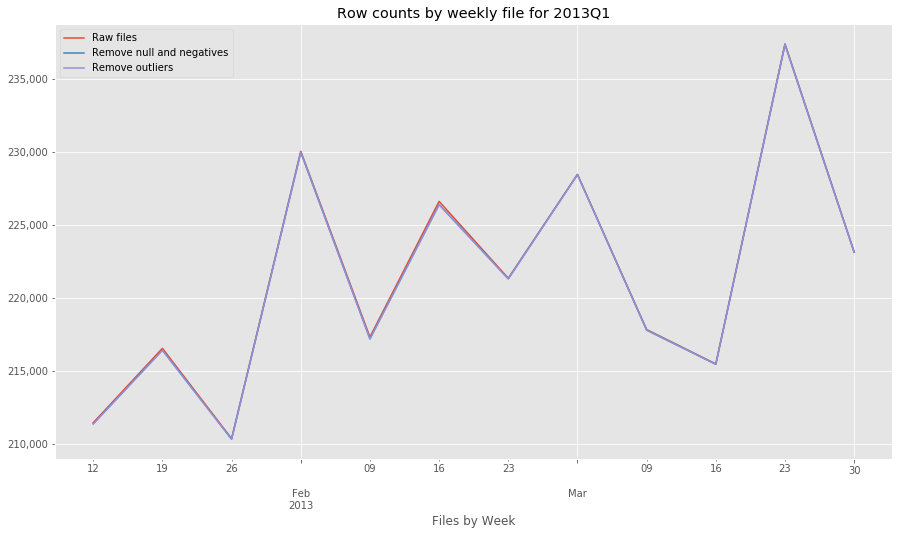

In [555]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
plt.style.use('ggplot')

merged.columns = ['Raw files','Remove null and negatives','Remove outliers']
merged.index.name = 'Files by Week'
# removing the two tail ends because the files didnt fully match up 
ax = merged[merged['Remove null and negatives'].notnull()].iloc[1:-1].plot(figsize=(15,8), title='Row counts by weekly file for 2013Q1')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f_format.format(y)))

### Daily Entries/Exits

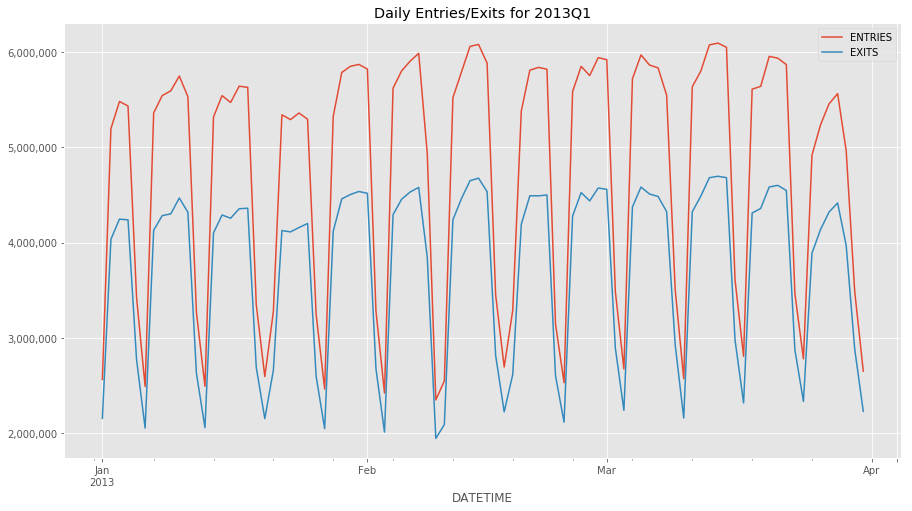

In [553]:
ax = df_dt_index_positive_outliers_removed['2013Q1'].resample('D')[value_columns].sum().plot(figsize=(15,8), title='Daily Entries/Exits for 2013Q1')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f_format.format(y)))

### Mean and STD for Entries/Exits

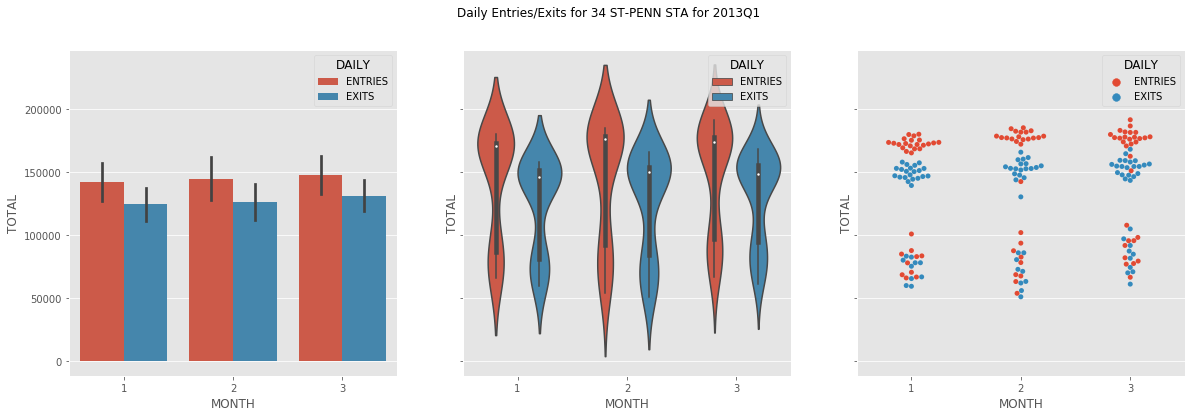

In [552]:
station = '34 ST-PENN STA'
penn_st = df_dt_index_positive_outliers_removed['2013Q1'].groupby(
    'STATION'
).get_group(station).resample('D')[value_columns].sum()

# mean = mean.mean(axis=1)
# std  = df.std(axis=1)
# ax.errorbar(df.index, mean, yerr=std, fmt='-o') #fmt=None to plot bars only

penn_st['MONTH'] = penn_st.index.month
melted = penn_st.reset_index().melt(
    id_vars=['DATETIME', 'MONTH'], 
    var_name='DAILY', 
    value_name='TOTAL', 
    value_vars=value_columns
)

# melted.head()
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
f.suptitle("Daily Entries/Exits for {} for 2013Q1".format(station))
sns.barplot(x='MONTH', y='TOTAL', data=melted, hue='DAILY', ax=ax1)
sns.violinplot(x='MONTH', y='TOTAL', data=melted, hue='DAILY', ax=ax2)
sns.swarmplot(x='MONTH', y='TOTAL', data=melted, hue='DAILY', ax=ax3)

### Station closures and reduced capacity

Not entirely sure if my plots and logic are correct for this one

In [587]:
q12013 = df_dt_index_positive_outliers_removed['2013Q1']
stations = q12013.groupby(['STATION','UNIT', q12013.index.date])['BUSYNESS'].sum().reset_index()

In [606]:
stations['UNIT_CLOSED'] = stations.apply(lambda r: True if r['BUSYNESS'] < 10 else False, axis=1)

In [607]:
stations = stations.assign(STATION_CLOSED=stations.groupby(
    ['STATION','level_2'], as_index=False,
)['BUSYNESS'].transform(lambda g: True if g.sum() < 100 else False))


In [608]:
stations['REDUCED_CAPACITY'] = stations.apply(
    lambda g: True if g['UNIT_CLOSED'] == False and g['STATION_CLOSED'] == False else False, axis=1
)

In [609]:
stations['REDUCED_CAPACITY'] = stations.groupby(
    ['STATION', 'level_2']
)['REDUCED_CAPACITY'].transform(lambda g: True if g.sum() > 0 else False)



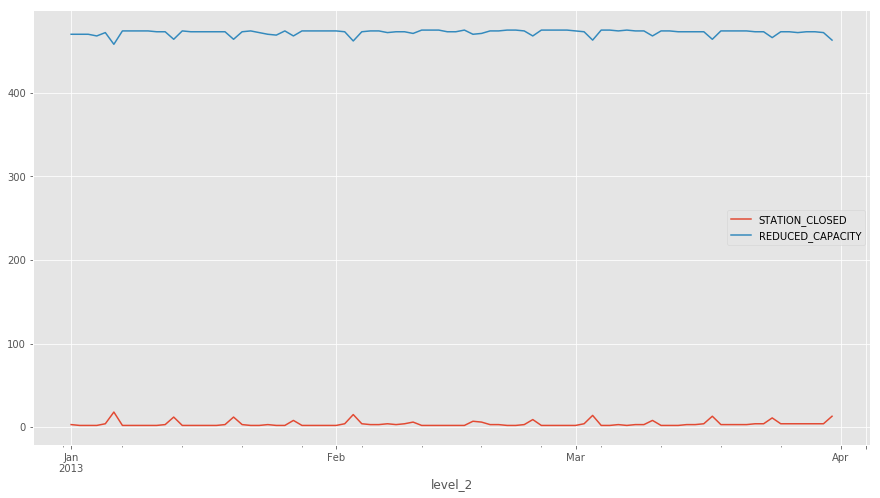

In [612]:
stations.set_index(
    pd.DatetimeIndex(stations['level_2'])
).resample('D')[['STATION_CLOSED','REDUCED_CAPACITY']].sum().plot(figsize=(15,8))